> # EDA - Phase 2

1. item_price_month ( mean value ）
1. Sales vs Price
1. Sales vs Month
> *+ From EDA phase 1*
1. item_name

In [1]:
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 496.4MB 18kB/s 
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: pytorch-transformers 1.1.0 has requirement torch>=1.0.0, but you'll have torch 0.3.1 which is incompatible.
ERROR: pytorch-pretrained-bert 0.6.2 has requirement torch>=0.4.1, but you'll have torch 0.3.1 which is incompatible.
ERROR: catalyst 19.11.6 has requirement torch>=1.0.0, but you'll have torch 0.3.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
ERROR: allennlp 0.9.0 has requirement torch>=1.2.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.3.0
    Uninstalling torch-1.3.0:
      Successfully uninstalled torch-1.3.0
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.structured import *

In [3]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')

 > ## 1/ Add  item_price_month （ mean value ）

In [4]:
# merge csv into train
train = train.merge(shops, on='shop_id')
train = train.merge(items, on='item_id')
train = train.merge(cats, on='item_category_id')
train.drop('item_category_id', 1, inplace=True)

# convert daily sales to monthly sales
g = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
g.columns = ['item_cnt_month']
g.item_cnt_month = g.item_cnt_month.clip(0, 20)
train = train.merge(g.reset_index(), how='left', on=['date_block_num','shop_id','item_id'])

# use monthly mean value to update price
g = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
g.columns = ['item_price_month']
train = train.merge(g.reset_index(), how='left', on=['date_block_num','shop_id','item_id'])

# drop useless value
train.drop(['date', 'item_price', 'item_cnt_day'], 1, inplace=True)
train.drop_duplicates(inplace=True)
train = train.sort_values('date_block_num').reset_index(drop=True)

# convert category data to one-hot code
train_cats(train)
df, y, nas = proc_df(train, 'item_cnt_month')

train.tail()

,date_block_num,shop_id,item_id,shop_name,item_name,item_category_name,item_cnt_month,item_price_month
1609119,33,37,13363,"Новосибирск ТЦ ""Мега""","Компл.вопр.серт.экзам. по Платформе 8.3, февра...",Книги - Методические материалы 1С,1.0,299.0
1609120,33,57,12957,"Якутск Орджоникидзе, 56",КРУГ ИРИНА Матерая любовь,Музыка - CD локального производства,1.0,229.0
1609121,33,7,4178,"Воронеж ТРЦ ""Максимир""",Kaspersky Internet Security Multi-Device Russi...,Программы - Для дома и офиса,6.0,1590.0
1609122,33,18,10776,"Красноярск ТЦ ""Июнь""",ДДТ Единочество 2CD (фирм.),Музыка - CD локального производства,1.0,399.0
1609123,33,55,13092,Цифровой склад 1С-Онлайн,Карта оплаты Windows: 2000 рублей [Цифровая ве...,Карты оплаты - Windows (Цифра),1.0,2000.0


In [5]:
df

,date_block_num,shop_id,item_id,shop_name,item_name,item_category_name,item_price_month
0,0,59,22154,60,21792,38,999.000000
1,0,8,14050,9,13794,41,349.000000
2,0,52,20005,53,19687,44,249.000000
3,0,13,14050,14,13794,41,224.000000
4,0,31,14050,32,13794,41,334.571429
...,...,...,...,...,...,...,...
1609119,33,37,13363,38,13119,50,299.000000
1609120,33,57,12957,58,12736,56,229.000000
1609121,33,7,4178,8,4095,76,1590.000000
1609122,33,18,10776,19,10576,56,399.000000


 > ## 2/ Sales vs Price

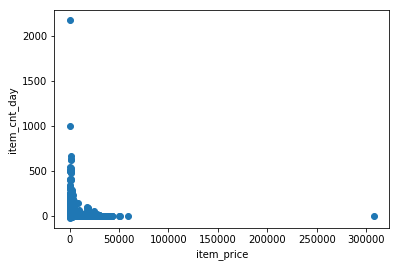

In [6]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')

# reverse relationship
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.scatter(sales_train['item_price'], sales_train['item_cnt_day'])
plt.show()

# remove outliers
sales_train = sales_train[(sales_train.item_price < 100000) & (sales_train.item_cnt_day <= 1000)]
sales_train.loc[sales_train.item_price <= 0, 'item_price'] = 2499.0

 > ## 3/ Sales vs Month

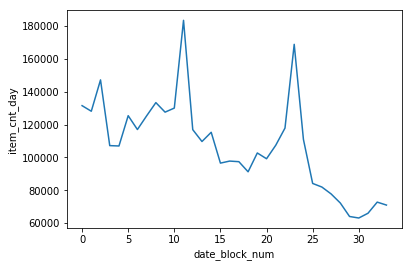

In [7]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
grouped = sales_train[['date_block_num','item_cnt_day']].groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index()

# Chiristmas Day has best sales
plt.xlabel('date_block_num')
plt.ylabel('item_cnt_day')
x=grouped['date_block_num']
y=grouped['item_cnt_day']
plt.plot(x, y)

  > ## *From phase 1*
  
  1. *items off shelves*
  1. *shops closed*
  1. *new items in test set*
  1. *split shop_name ( city & type )*
  1. *split item_category_name ( type & subtype )*

In [8]:
#1 outdated items
item_last = np.unique(g.loc[31:].reset_index().item_id.values)
item_all = np.unique(g.reset_index().item_id.values)
n_item_outdated = len(list(set(item_all) - set(item_last)))
n_item_outdated, n_item_outdated / len(item_all)
(14620, 0.6704576722003118)

#2 closed shops
shop_last = np.unique(g.loc[31:].reset_index().shop_id.values)
shop_all = np.unique(g.reset_index().shop_id.values)
n_shop_closed = len(list(set(shop_all) - set(shop_last)))
n_shop_closed, n_shop_closed / len(shop_all)
(14, 0.23333333333333334)

#3 new items in test set
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))),  \
len(list(set(test.item_id))), len(test)
(363, 5100, 214200)

(363, 5100, 214200)

In [9]:
#4 split shop_name ( city & type )
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
train.loc[train.shop_id == 39, 'shop_id'] = 40
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name == 'Цифровой склад 1С-Онлайн', 'shop_name'] = 'Цифровойсклад 1С-Онлайн'
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_type'] = shops.shop_name.str.split(' ')\
          .map(lambda x: 'ТЦ' if 'ТЦ' == x[1] else  'ТРЦ' if 'ТРЦ' == x[1] else
           'ТК' if 'ТК' == x[1] else 'ТРК' if 'ТРК' == x[1] else 'МТРЦ' if 'МТРЦ' == x[1] else 'other')
shops['city_code'] = LabelEncoder().fit_transform(shops['city']).astype(np.int8)
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type']).astype(np.int8)
shops = shops[['shop_id', 'city_code', 'shop_type_code']]
shops.head()

,shop_id,city_code,shop_type_code
0,0,29,0
1,1,29,5
2,2,0,5
3,3,1,3
4,4,2,5


In [10]:
#5 split item_category_name ( type & subtype )
cats.loc[32, 'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
cats['type'] = cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
cats['subtype'] = cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else np.nan)
cats['type_code'] = LabelEncoder().fit_transform(cats['type']).astype(np.int8)
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'].fillna('xxx')).astype(np.int8)
cats = cats[['item_category_id', 'type_code', 'subtype_code']]
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
item_names = items.item_name.values
pat = re.compile(r'\((.*?)\)', re.S)
item_f1, item_f2, features = [], [], []
for o in item_names:
  features.append(re.findall(pat, o)[-2:])
for o in features:
  if len(o) == 0:
    item_f1.append(np.nan)
    item_f2.append(np.nan)
  elif len(o) == 1:
    item_f1.append(o[0])
    item_f2.append(np.nan)
  else:
    item_f1.append(o[1])
    item_f2.append(o[0])
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.uint8)
items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], 1, inplace=True)
items.head()

,item_id,item_category_id,item_f1_code,item_f2_code
0,0,40,836,138
1,1,76,729,138
2,2,40,671,138
3,3,40,673,138
4,4,40,864,138


> # Feature Engineering

1. lag features
1. mean encoding features
1. ratio features —— price trend
1. ratio features —— revenue trend

In [13]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from fastai.structured import *

In [14]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')

In [15]:
# copy from eda
train = train[(train.item_price < 100000) & (train.item_cnt_day <= 1000)]
train.loc[train.item_price <= 0, 'item_price'] = 2499.0

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
train.loc[train.shop_id == 39, 'shop_id'] = 40
test.loc[test.shop_id == 39, 'shop_id'] = 40
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name == 'Цифровой склад 1С-Онлайн', 'shop_name'] = 'Цифровойсклад 1С-Онлайн'
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_type'] = shops.shop_name.str.split(' ')\
          .map(lambda x: 'ТЦ' if 'ТЦ' == x[1] else  'ТРЦ' if 'ТРЦ' == x[1] else
           'ТК' if 'ТК' == x[1] else 'ТРК' if 'ТРК' == x[1] else 'МТРЦ' if 'МТРЦ' == x[1] else 'other')
shops['city_code'] = LabelEncoder().fit_transform(shops['city']).astype(np.int8)
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type']).astype(np.int8)
shops = shops[['shop_id', 'city_code', 'shop_type_code']]

cats.loc[32, 'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
cats['type'] = cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
cats['subtype'] = cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else np.nan)
cats['type_code'] = LabelEncoder().fit_transform(cats['type']).astype(np.int8)
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'].fillna('xxx')).astype(np.int8)
cats = cats[['item_category_id', 'type_code', 'subtype_code']]

item_names = items.item_name.values
pat = re.compile(r'\((.*?)\)', re.S)
item_f1, item_f2, features = [], [], []
for o in item_names:
  features.append(re.findall(pat, o)[-2:])
for o in features:
  if len(o) == 0:
    item_f1.append(np.nan)
    item_f2.append(np.nan)
  elif len(o) == 1:
    item_f1.append(o[0])
    item_f2.append(np.nan)
  else:
    item_f1.append(o[1])
    item_f2.append(o[0])
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.uint8)
items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], 1, inplace=True)

In [16]:
matrix = []
cols = ['date_block_num','shop_id','item_id']

# select all the unique pairs (shop-item)
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
...,...,...,...
10697061,33,59,22162
10697251,33,59,22163
10697917,33,59,22164
10699443,33,59,22166


In [17]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [18]:
# covert daily sales to monthly (alsp clip20)
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

# merge all features
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,subtype_code
0,0,0.0,19,2,0,5,40,729,138,10,4
1,0,1.0,27,2,0,5,19,729,138,5,10
2,0,0.0,28,2,0,5,30,729,138,8,53
3,0,0.0,29,2,0,5,23,729,138,5,16
4,0,0.0,32,2,0,5,40,729,138,10,4
...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,0.0,18454,45,20,5,55,729,138,12,2
11056273,34,0.0,16188,45,20,5,64,729,138,13,41
11056274,34,0.0,15757,45,20,5,55,729,138,12,2
11056275,34,0.0,19648,45,20,5,40,853,138,10,4


 > ## 1/ lag features

In [19]:
# define lag fuction (dataframe, lags, column)
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

 > ## 2/ mean encoding
 
* **date_avg_item_cnt——【1】**：*mean monthly sales for 1C company ( 反映公司整体经营状况 )*
* **date_item_avg_item_cnt——【1/2/3/6/12】**:  *mean monthly sales per ITEM（反应单个商品的市场表现）*
* **date_shop_avg_item_cnt——【1/2/3/6/12】**: *mean monthly sales per SHOP（反应单个商店的市场表现）*
* **date_cat_avg_item_cnt——【1】**: *mean monthly sales per ITEM-CATEGORY（反应单个商品类别的市场表现）*
* **date_cat_item_f1_avg_item_cnt——【1】**: *mean monthly sales per ITEM-CATEGORY-F1（反应单个商品类别-子类别“ 1 ”的市场表现）*
* **date_cat_item_f2_avg_item_cnt——【1】**: *mean monthly sales per ITEM-CATEGORY-F2（反应单个商品类别-子类别“ 2 ”的市场表现）*
* **date_shop_cat_avg_item_cnt——【1】**: *mean monthly sales per SHOP per ITEM-CATEGORY（反应单个商店单个商品类别的市场表现）*
* **date_shop_type_avg_item_cnt——【1】**: *mean monthly sales per SHOP-TYPE （反应单个商店类型- "主类型" 的市场表现）*
* **date_shop_subtype_avg_item_cnt——【1】**: *mean monthly sales per SHOP-SUBTYPE （反应单个商店类型- "副类型" 的市场表现）*
* **date_city_avg_item_cnt——【1】**: *mean monthly sales per CITY （反应单个城市的商业环境）*


In [20]:
# calculate the mean monthly sales for 1C company
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [21]:
group.loc[0:4]

,date_block_num,date_avg_item_cnt
0,0,0.347168
1,1,0.324463
2,2,0.355469
3,3,0.275391
4,4,0.265137


In [22]:
matrix

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,subtype_code,date_avg_item_cnt_lag_1
0,0,0.0,19,2,0,5,40,729,138,10,4,NaN
1,0,1.0,27,2,0,5,19,729,138,5,10,NaN
2,0,0.0,28,2,0,5,30,729,138,8,53,NaN
3,0,0.0,29,2,0,5,23,729,138,5,16,NaN
4,0,0.0,32,2,0,5,40,729,138,10,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,0.0,18454,45,20,5,55,729,138,12,2,0.258545
11056273,34,0.0,16188,45,20,5,64,729,138,13,41,0.258545
11056274,34,0.0,15757,45,20,5,55,729,138,12,2,0.258545
11056275,34,0.0,19648,45,20,5,40,853,138,10,4,0.258545


In [23]:
# calculate the mean monthly sales per ITEM （last 1/2/3/6/12 month）
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per SHOP （last 1/2/3/6/12 month）
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per ITEM-CATEGORY （last 1 month）
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per ITEM-CATEGORY-F1 （last 1 month）
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_item_f1_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f1_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f1_avg_item_cnt')
matrix.drop(['date_cat_item_f1_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per ITEM-CATEGORY-F2 （last 1 month）
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_item_f2_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f2_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f2_avg_item_cnt')
matrix.drop(['date_cat_item_f2_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per ？ （last 1 month）
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per SHOP-TYPE （last 1 month）
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per SHOP-SUBTYPE （last 1 month）
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

# calculate the mean monthly sales per CITY （last 1 month）
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [24]:
matrix

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt,date_cat_item_f2_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
0,0,0.0,19,2,0,5,40,729,138,10,...,NaN,NaN,NaN,NaN,0.292236,NaN,NaN,NaN,NaN,NaN
1,0,1.0,27,2,0,5,19,729,138,5,...,NaN,NaN,NaN,NaN,0.807129,NaN,NaN,NaN,NaN,NaN
2,0,0.0,28,2,0,5,30,729,138,8,...,NaN,NaN,NaN,NaN,1.140625,NaN,NaN,NaN,NaN,NaN
3,0,0.0,29,2,0,5,23,729,138,5,...,NaN,NaN,NaN,NaN,0.550781,NaN,NaN,NaN,NaN,NaN
4,0,0.0,32,2,0,5,40,729,138,10,...,NaN,NaN,NaN,NaN,0.292236,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,0.0,18454,45,20,5,55,729,138,12,...,0.137573,NaN,0.196899,0.196655,0.000000,0.197021,0.126831,0.089294,0.126831,0.135376
11056273,34,0.0,16188,45,20,5,64,729,138,13,...,NaN,NaN,0.155884,0.159302,0.000000,0.155884,0.094482,0.106201,0.094482,0.135376
11056274,34,0.0,15757,45,20,5,55,729,138,12,...,0.137573,0.181274,0.196899,0.196655,0.000000,0.197021,0.126831,0.089294,0.126831,0.135376
11056275,34,0.0,19648,45,20,5,40,853,138,10,...,0.137573,NaN,0.220825,0.118958,0.000000,0.223267,0.083740,0.097046,0.083740,0.135376


 > ## 3/ price trend features

* **item_avg_item_price**: *mean prices of an item in all time* ( 反映单个商品的历史价格总均值，33个月 )
* **date_item_avg_item_price** : *mean price of an item in every month* ( 反映单个商品、历史单月价格均值 )
* **delta_price_lag——【1/2/3/4/5/6】**: * price fluctuation by month* ( 反映单个商品、历史单月价格波动情况。 等于以上二者比值减1 )

In [25]:
# mean price of items in all time
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# mean price of items in every month
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [26]:
# add features created above
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# show the ratio of price fluctuation
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [27]:
matrix

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,...,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6
0,0,0.0,19,2,0,5,40,729,138,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,27,2,0,5,19,729,138,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,28,2,0,5,30,729,138,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.0,29,2,0,5,23,729,138,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.0,32,2,0,5,40,729,138,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,0.0,18454,45,20,5,55,729,138,12,...,99.000,99.0,98.9375,199.000,-0.475098,-0.475098,-0.475098,-0.475098,-0.475586,0.054993
11056273,34,0.0,16188,45,20,5,64,729,138,13,...,NaN,NaN,NaN,NaN,0.081116,-0.027054,NaN,NaN,NaN,NaN
11056274,34,0.0,15757,45,20,5,55,729,138,12,...,229.000,229.0,229.0000,208.125,0.155884,0.155884,0.155884,0.155884,0.155884,0.050476
11056275,34,0.0,19648,45,20,5,40,853,138,10,...,94.875,99.0,99.0000,99.000,-0.091736,0.008919,-0.033112,0.008919,0.008919,0.008919


In [28]:
# integrate to a trend 
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

 > ## 4/ revenue trend features
 
* **date_shop_revenue** : *revenue of a shop by month* ( 反映单个商店，单月的盈利之和 )
* **shop_avg_revenue** : *mean revenue of a shop in every month* ( 反映单个商店，单月的平均盈利 )
* **delta_revenue** : *revenue trend of a shop in every month* ( 反映单个商店每月的盈利趋势，为以上二者比值减1 )
* **delta_revenue_lag_1——【1】** : *revenue trend of a shop from the last month* ( 反映单个商店上月的盈利趋势 )

In [29]:
# sum revenue by shops
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# mean encoding
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# revenue trend
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [30]:
matrix

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,...,date_cat_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt,date_cat_item_f2_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0.0,19,2,0,5,40,729,138,10,...,NaN,NaN,0.292236,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,1.0,27,2,0,5,19,729,138,5,...,NaN,NaN,0.807129,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,0.0,28,2,0,5,30,729,138,8,...,NaN,NaN,1.140625,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,0.0,29,2,0,5,23,729,138,5,...,NaN,NaN,0.550781,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,0.0,32,2,0,5,40,729,138,10,...,NaN,NaN,0.292236,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,0.0,18454,45,20,5,55,729,138,12,...,0.196899,0.196655,0.000000,0.197021,0.126831,0.089294,0.126831,0.135376,-0.475098,-0.290039
11056273,34,0.0,16188,45,20,5,64,729,138,13,...,0.155884,0.159302,0.000000,0.155884,0.094482,0.106201,0.094482,0.135376,0.081116,-0.290039
11056274,34,0.0,15757,45,20,5,55,729,138,12,...,0.196899,0.196655,0.000000,0.197021,0.126831,0.089294,0.126831,0.135376,0.155884,-0.290039
11056275,34,0.0,19648,45,20,5,40,853,138,10,...,0.220825,0.118958,0.000000,0.223267,0.083740,0.097046,0.083740,0.135376,-0.091736,-0.290039


> # XGboost

In [31]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import gc
import pickle
import pandas as pd

In [32]:
matrix.to_pickle('data.pkl')
del matrix
del group
del items
del shops
del cats
del train
gc.collect();

In [33]:
data = pd.read_pickle('data.pkl')
data = data[['date_block_num',
             'item_cnt_month',
             'item_id',
             'shop_id',
             'city_code',
             'item_category_id',
             'item_f1_code',
             'item_f2_code',
             'type_code',
             'subtype_code',
             'shop_type_code',
             'date_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_lag_2',
             'date_item_avg_item_cnt_lag_3',
             'date_item_avg_item_cnt_lag_6',
             'date_item_avg_item_cnt_lag_12',
             'date_shop_avg_item_cnt_lag_1',
             'date_shop_avg_item_cnt_lag_2',
             'date_shop_avg_item_cnt_lag_3',
             'date_shop_avg_item_cnt_lag_6',
             'date_shop_avg_item_cnt_lag_12',
             'date_cat_avg_item_cnt_lag_1',
             'date_cat_item_f1_avg_item_cnt_lag_1',
             'date_cat_item_f2_avg_item_cnt_lag_1',
             'date_shop_cat_avg_item_cnt_lag_1',
             'date_shop_type_avg_item_cnt_lag_1',
             'date_shop_subtype_avg_item_cnt_lag_1',
             'date_city_avg_item_cnt_lag_1',
             'delta_price_lag',
             ]]

In [34]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
gc.collect();

In [35]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:39] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15279	validation_1-rmse:1.132
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13244	validation_1-rmse:1.10619
[2]	validation_0-rmse:1.10709	validation_1-rmse:1.08194
[3]	validation_0-rmse:1.07945	validation_1-rmse:1.06085
[4]	validation_0-rmse:1.05927	validation_1-rmse:1.04441
[5]	validation_0-rmse:1.04278	validation_1-rmse:1.03027
[6]	validation_0-rmse:1.02996	validation_1-rmse:1.01818
[7]	validation_0-rmse:1.01794	validation_1-rmse:1.00806
[8]	validation_0-rmse:1.00993	validation_1-rmse:0.9983

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [36]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({"ID": test.index, "item_cnt_month": Y_test})
submission.to_csv('xgb_submission.csv', index=False)

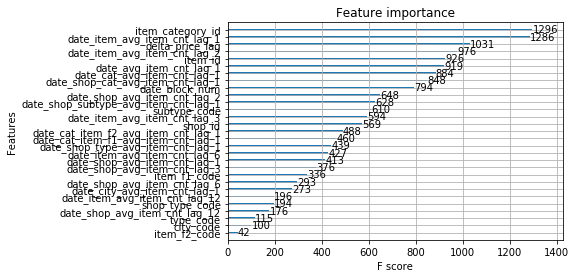

In [37]:
from matplotlib import  pyplot
plot_importance(model)
pyplot.show()